In [1]:
%matplotlib inline
from netCDF4 import Dataset as ncread
import netCDF4 as nc
import numpy as np
from scipy.io import loadmat
import pandas as pd
import h5py
import math
import pandas as pd
from datetime import datetime
from itertools import product
from cftime import DatetimeNoLeap
import xarray as xr

In [2]:
from preprocess import get_principle_components_and_EOFs
import os
import visualization

In [3]:
%load_ext autoreload
%autoreload

In [4]:
import matplotlib.pyplot as plt
from matplotlib import rcParams #For changing text properties
import cmocean #A package with beautiful colormaps
import matplotlib.path as mpath

In [5]:
from datetime import datetime 
from datetime import timedelta
from datetime import date
import time

In [6]:
import warnings
warnings.filterwarnings("ignore", message="invalid value encountered in true_divide")

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.utils import shuffle

In [8]:
import tensorflow as tf    
#tf.compat.v1.disable_v2_behavior() # <-- HERE !

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout, Activation, Reshape, Flatten, LSTM, Dense, Dropout, Embedding, Bidirectional, GRU
from tensorflow.keras import Sequential
from tensorflow.keras import initializers, regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import constraints
from tensorflow.keras.layers import Layer, InputSpec

## Data set

Frozen(SortedKeysDict({'latitude': 28, 'longitude': 31}))

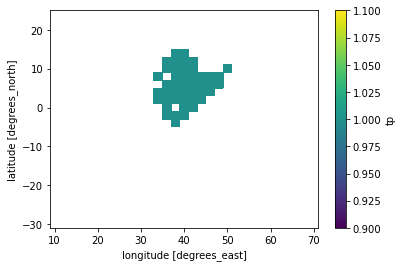

In [9]:
# Import regional mask
root_data = '/s2s_nobackup/zhengwu/workshop/'

import pathlib
root_results = '/s2s_nobackup/zhengwu/workshop/Results'

file = 'era5_hoa_dry_mask_2deg.nc' #0.25

mask=xr.open_mfdataset(root_data+file,combine='by_coords',parallel=True)
mask_nan=mask.where(mask==1) #keep the values==1 and mask the rest
mask_nan.tp.plot()
mask_nan.sizes

#### Prepare target 
#### define drought events when 31-day running mean rainfall in OND from 1980-2021 is below the 33rd percentile, the tercile is calculated based on the 2000-2020 period

In [10]:
SYY = 1981   # start year, could be changed
EYY = 2020   # end year, could be changed


drop_OND_years = [2005,2007,2018,2004,2006]
take_OND_years = list(np.arange(SYY,EYY+1))
take_OND_years = [y for y in take_OND_years if y not in drop_OND_years]
# drop_MAM_years = [2009,2001,2002,2005,2020]

In [11]:
# Calculate the spatial mean of the tp file after applying the spatial mask

file=xr.open_mfdataset(root_data+f'/chrips_precip_1981-2021.nc',
                          combine='by_coords').compute()
tp_dim=file.sel(longitude=slice(38,53),latitude=slice(-5,8))
tp_series=tp_dim.mean(dim='latitude',skipna=True).mean(dim='longitude',skipna=True)

# Calculate 33 percentile
# Create daily values equal to a 31 day rolling. Select OND 2000-2020 data to decide the quantile threshold
tp_rol=tp_series.rolling(time=28, center=True).mean().sel(time=tp_series.time.dt.year.isin([np.arange(2000,2021)]))
tp_quantile=tp_rol.sel(time=tp_rol.time.dt.month.isin([10,11,12])).quantile(0.33)
print('value of the 33 percentile',tp_quantile.precip.values)


# Create index time series
# Replace the values bellow the 33 percentile with 1 and the rest with zeros
#tp_rol = tp_series.rolling(time=28, center=True).mean().sel(time=tp_series.time.dt.month.isin([10,11,12]))
tp_rol_tmp = tp_series.rolling(time=28, center=True).mean()
tp_rol = tp_rol_tmp.groupby(tp_rol_tmp.time.dt.dayofyear).quantile(q=0.33,dim='time')

# orignal sorting
#tp_rol_sel = tp_rol.sel(time = slice(str(SYY),str(EYY)))
#tp_index = tp_rol_sel < tp_quantile
#tp_index = tp_index.sel(time=tp_index.time.dt.year.isin(take_OND_years))
#tp_index = tp_index.astype(int)
#print('tp index',tp_index)

# Sem's sorting
tp_tercile = (tp_rol_tmp.groupby(tp_rol_tmp.time.dt.dayofyear) < tp_rol).astype(int).drop('dayofyear').drop('quantile')
tp_index = tp_tercile.sel(time=tp_tercile.time.dt.year.isin(take_OND_years))
tp_index = tp_index.astype(int)
print('tp index',tp_index)

/net/cfc/s2s/s2s_ai_challenge/conda/envs/s2sai_2020/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


value of the 33 percentile 0.7921251404285431
tp index <xarray.Dataset>
Dimensions:  (time: 12784)
Coordinates:
  * time     (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2020-12-31
Data variables:
    precip   (time) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0


In [12]:
tp_index_test = tp_tercile.sel(time=tp_tercile.time.dt.year.isin(drop_OND_years))
tp_index_test = tp_index_test.astype(int)
print('tp index for final evaluation',tp_index_test)

tp index for final evaluation <xarray.Dataset>
Dimensions:  (time: 1826)
Coordinates:
  * time     (time) datetime64[ns] 2004-01-01 2004-01-02 ... 2018-12-31
Data variables:
    precip   (time) int64 1 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0


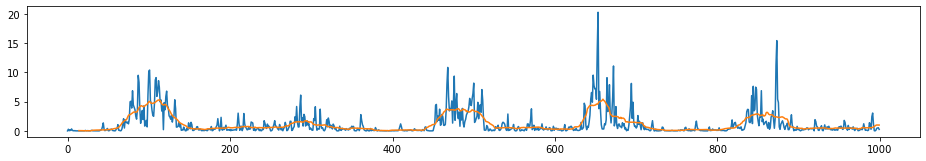

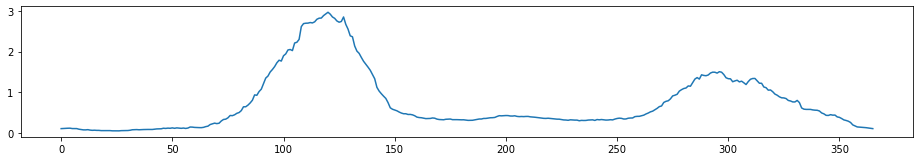

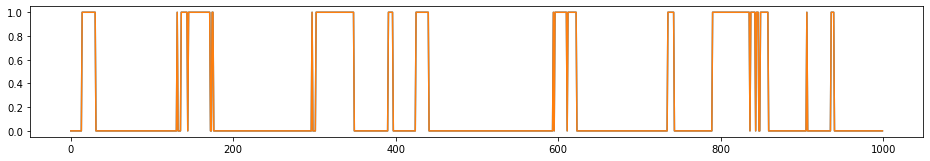

In [13]:
fig, axs = plt.subplots(1, figsize=plt.figaspect(0.15))
plt.plot(tp_series['precip'].values[0:1000])
plt.plot(tp_rol_tmp['precip'].values[0:1000])
fig, axs = plt.subplots(1, figsize=plt.figaspect(0.15))
plt.plot(tp_rol['precip'].values)
fig, axs = plt.subplots(1, figsize=plt.figaspect(0.15))
plt.plot(tp_tercile['precip'].values[0:1000])
plt.plot(tp_index['precip'].values[0:1000])

number of 0 and 1:  (array([0, 1]), array([1427,  743]))
<xarray.Dataset>
Dimensions:  (time: 2170)
Coordinates:
  * time     (time) datetime64[ns] 1981-10-16 1981-10-17 ... 2020-12-16
Data variables:
    precip   (time) int64 0 0 0 0 0 0 0 0 0 1 0 0 0 ... 1 1 1 1 0 0 1 1 1 1 1 1
(2170,)


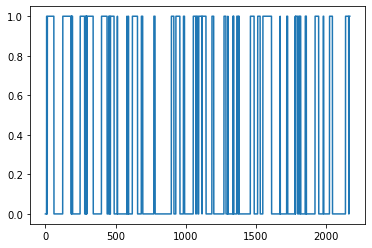

In [14]:
# Select from the index time series the period for the target values (predictant) 
# Oct 16 to Dec 16 for the period 1980-2020 (each day corresponds to a 31-day rolling mean)
# The chosen time period could be changed to any time period you want
for iyr in range(SYY,EYY+1):
    if iyr == SYY:
        tp_target = tp_index.sel(time = slice(str(iyr)+'-10-16',str(iyr)+'-12-16'))
    else:
        tp_target = xr.concat([tp_target,tp_index.sel(time = slice(str(iyr)+'-10-16',str(iyr)+'-12-16'))], dim='time')
print('number of 0 and 1: ',np.unique(tp_target['precip'],return_counts=True))
print(tp_target)
plt.plot(tp_target.precip)

# Make it into a numpy array
target2 = tp_target['precip']
target = tp_target['precip'].values
print(target.shape)

number of 0 and 1:  (array([0, 1]), array([225,  85]))
<xarray.Dataset>
Dimensions:  (time: 310)
Coordinates:
  * time     (time) datetime64[ns] 2005-10-16 2005-10-17 ... 2006-12-16
Data variables:
    precip   (time) int64 1 1 1 1 0 0 0 0 0 1 1 1 1 ... 0 0 0 0 0 0 0 0 0 0 0 0
(310,)


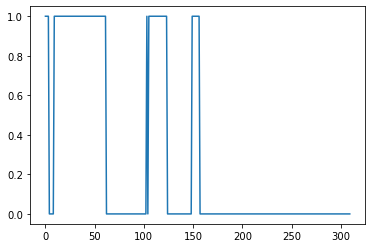

In [15]:
# target for final evaluation
for iyr in range(len(drop_OND_years)):
    if iyr == 0:
        tp_target_test = tp_index_test.sel(time = slice(str(drop_OND_years[iyr])+'-10-16',str(drop_OND_years[iyr])+'-12-16'))
    else:
        tp_target_test = xr.concat([tp_target_test,tp_index_test.sel(time = slice(str(drop_OND_years[iyr])+'-10-16',str(drop_OND_years[iyr])+'-12-16'))], dim='time')
print('number of 0 and 1: ',np.unique(tp_target_test['precip'],return_counts=True))
print(tp_target_test)
plt.plot(tp_target_test.precip)

target2_test = tp_target_test['precip']
target_test = tp_target_test['precip'].values
print(target_test.shape)

In [16]:
tmp = np.arange(0,(EYY-SYY+1-5)*62,62)
tp_count = []
for iday in range(62):
    tp_count.append(target[tmp].sum())
    #print(target[tmp])
    tmp = tmp+1
tp_prob_clim_tmp = np.array(tp_count) / (EYY-SYY+1-5)
print(tp_count,tp_prob_clim_tmp)
tp_prob_clim = np.tile(tp_prob_clim_tmp, (EYY-SYY+1-5))
time_dim = tp_target.coords['time']
tp_prob_clim = xr.DataArray(tp_prob_clim, coords={'time': time_dim}, dims=["time"])
tp_prob_clim

[11, 12, 12, 13, 13, 13, 12, 13, 12, 13, 12, 12, 11, 12, 12, 12, 12, 13, 12, 12, 12, 12, 11, 12, 11, 11, 11, 10, 11, 10, 12, 12, 11, 12, 12, 13, 12, 12, 12, 13, 13, 12, 13, 12, 12, 12, 13, 12, 12, 12, 12, 12, 12, 11, 12, 12, 12, 12, 13, 12, 12, 12] [0.31428571 0.34285714 0.34285714 0.37142857 0.37142857 0.37142857
 0.34285714 0.37142857 0.34285714 0.37142857 0.34285714 0.34285714
 0.31428571 0.34285714 0.34285714 0.34285714 0.34285714 0.37142857
 0.34285714 0.34285714 0.34285714 0.34285714 0.31428571 0.34285714
 0.31428571 0.31428571 0.31428571 0.28571429 0.31428571 0.28571429
 0.34285714 0.34285714 0.31428571 0.34285714 0.34285714 0.37142857
 0.34285714 0.34285714 0.34285714 0.37142857 0.37142857 0.34285714
 0.37142857 0.34285714 0.34285714 0.34285714 0.37142857 0.34285714
 0.34285714 0.34285714 0.34285714 0.34285714 0.34285714 0.31428571
 0.34285714 0.34285714 0.34285714 0.34285714 0.37142857 0.34285714
 0.34285714 0.34285714]


<xarray.DataArray (time: 2170)>
array([0.31428571, 0.34285714, 0.34285714, ..., 0.34285714, 0.34285714,
       0.34285714])
Coordinates:
  * time     (time) datetime64[ns] 1981-10-16 1981-10-17 ... 2020-12-16

#### Prepare predictors: 30 days time series with the last day two weeks before the target day

In [17]:
# Predictor data preprocessing
# can select the values and region you want by changing the parameters

root_data = '/net/cfc/s2s/mpyrina/Lorentz_Workshop/Data/'
file_vars = ['ERA5_t2m', 'era5_t_850hpa', 'era5_z_200hpa', 'era5_z_500hpa', 'sst', 'era5_olr']
#file_vars = ['sst']
header_vars = ['t2m', 't', 'z', 'z', 'sst', 'olr-mean']
#header_vars = ['sst']

# select regions for the individual predictor
lon_slices = [[-16,54],[-30,90],[-30,90],[-30,90],[-180,180],[40,180]]
lat_slices = [[16,0],[30,-20],[-20,30],[-20,30],[40,-20],[-20,20]]

nmode = 5 # for eofs

for file_var, header_var, lon_slice, lat_slice in zip (file_vars, header_vars, lon_slices, lat_slices):
    # use existing
    path = root_results+'/PC_series_n_'+str(nmode)+'_var_'+file_var+'_.nc'
    path_eof = root_results+'/EOF_maps_n_'+str(nmode)+'_var_'+file_var+'_.nc'
    
    if os.path.exists(path):
        continue
    if file_var == 'era5_olr':
        file = xr.open_dataset(root_data+file_var+'_1950_2021_daily_1deg_tropics.nc')
        print('olr')
    else:
        file = xr.open_dataset(root_data+file_var+'_1959-2021_1_12_daily_2.0deg.nc')
        print(header_var)

    if "longitude" in file.coords:
        file = file.rename({"longitude": "lon","latitude": "lat"})

    assert "lat" in file.coords
    assert "lon" in file.coords
    
    # select region
    var_dim = file.sel(lon=slice(lon_slice[0],lon_slice[1]),lat=slice(lat_slice[0],lat_slice[1]))
    
    # todo: train_valid_test_split: exclude test    
    # take years 1980 - 2021 daily and only and 7 day rolling mean
    var_series = var_dim.sel(time=var_dim.time.dt.year.isin([np.arange(SYY,EYY+1)])).rolling(time=7, center=False).mean(skipna=True)
    var_series = var_series.sel(time=var_series.time.dt.year.isin(take_OND_years))

    # remove climatology
    var_anom_series = var_series.groupby("time.dayofyear") - var_series.groupby("time.dayofyear").mean("time",skipna=True)
    
    # use the months you want (base on how long the time series used as predictors)
    var_anom_sel = var_anom_series.sel(time=var_anom_series.time.dt.month.isin([7,8,9,10,11]))[header_var]
    
    # Apply EOF
    if file_var == "era5_z_500hpa":
        header_var = "z500"
    pc_xr, EOF = get_principle_components_and_EOFs(var_anom_sel, nmode=nmode)
    
    pc_xr = pc_xr.assign_coords(mode=[str(header_var)+'_'+str(int(m)) for m in pc_xr.mode])
    EOF = EOF.assign_coords(mode=[str(header_var)+'_'+str(int(m)) for m in EOF.mode])
    # save to disk
    pc_xr.to_netcdf(path)
    EOF.to_netcdf(path_eof)
    print(pc_xr)

In [18]:
# quick viz
# pc_xr.plot(hue="mode", figsize=(20,3))
# var_anom_series[header_var].isel(time=122).plot(size=5, aspect=4)

In [17]:
#exec(open('/home/mpyrina/Notebooks/Lorentz_workshop/L_functions.py').read())

from L_functions import sel_train_data_lead

#Create predictor multi-file
nc_in_file='PC_serie*.nc'
dim_to_stack='mode'
pc_xr = xr.open_mfdataset(root_results+"/"+nc_in_file,concat_dim=dim_to_stack,
                          combine="nested")# 

# Run the function
s_target_date='16-10-1981'
e_target_date='16-12-2020'
rw_1=7
lead_time=15
rw=28 # because the data are not centered
ntimestep=60
target_len=len(tp_target['precip'])

predictor_array=sel_train_data_lead(pc_xr, target_len, s_target_date, e_target_date,
                rw_1, lead_time, rw, ntimestep)

np_out_name='Predictor_array_crosscor_number.nc'

#np.save(root_results+np_out_name,predictor_array)
predictor_array.to_netcdf(root_results+"/"+np_out_name)

starting
start target date 16 10 1981
end target 16 12 2020


In [18]:
predictor_array

,Array,Chunk
Bytes,1.04 MB,480 B
Shape,"(2170, 60)","(1, 60)"
Count,6527 Tasks,2170 Chunks
Type,int64,numpy.ndarray
,Array,Chunk
Bytes,31.25 MB,2.40 kB
Shape,"(2170, 60, 30)","(1, 60, 5)"
Count,39082 Tasks,13020 Chunks
Type,float64,numpy.ndarray


In [16]:
# plot EOF modes
import cartopy.crs as ccrs
import cartopy.feature as cf
ii = 1
color = 'RdBu_r' 
colorbarMin = -1
colorbarMax = 1
colorspace = 0.1
level = np.arange(colorbarMin,colorbarMax+colorspace,colorspace)
ax = plt.axes(projection=ccrs.cartopy.crs.PlateCarree(central_longitude=180))
h = ax.contourf(lon, lat, EOF[ii,:,:], level, transform=ccrs.PlateCarree(), cmap=color,extend='both')
cbar = plt.colorbar(h, orientation='horizontal', shrink=1,fraction=0.1,pad=0.1,aspect=40)
cbar.ax.tick_params(labelsize=10) 
colorLabel='SST EOF [K]'
cbar.set_label(label=colorLabel,fontsize=10)
#Add in the coordinate system:
long = np.arange(-180, 180, 45)#spacing of 45 degrees
latg = np.arange(-20, 40, 10)#spacing of 15 degrees
ax.set_xticks(long, crs=ccrs.PlateCarree());
ax.set_yticks(latg, crs=ccrs.PlateCarree());
ax.set_xticklabels(long,fontsize=8)
ax.set_yticklabels(latg,fontsize=8)
ax.set_ylabel('lat',fontsize=10);
ax.set_xlabel('lon',fontsize=10);

#Add in the continents
#define the coastlines, the color (#000000) and the resolution (110m) 
feature1 = cf.NaturalEarthFeature(
    name='coastline', category='physical',
    scale='110m',
    edgecolor='#000000', facecolor='none')
#define the land, the color (#AAAAAA) and the resolution (110m), mask the land, use for SST
feature2 = cf.NaturalEarthFeature(
    name='land', category='physical',
    scale='110m',
    facecolor='#AAAAAA')

ax.add_feature(feature2)

#Set a title for your map:
title = 'SST JAS EOF'+str(ii+1)
plt.title(title,fontsize=10, y=1.03)

fig, axs = plt.subplots(1, figsize=plt.figaspect(0.15))
plt.plot(PC[:,ii])

ModuleNotFoundError: No module named 'cartopy'

## causal discovery with `tigramite`

In [16]:
# hard fix dates intersection
dates = tp_index.precip.time.to_index().intersection(pc_xr.time.to_index()).intersection(predictor_array.time.to_index())
tp_index = tp_index.sel(time=dates).compute()
target2 = target2.sel(time=dates).compute()
pc_xr = pc_xr.sel(time=dates).compute()
predictor_array = predictor_array.sel(time=dates).compute()

# NOTE: tp_index contains daily data for all the months while pc_xr only contains data for July-November. The input to PCMCI below are tp_index and pc_xr. So only need to select the same months from tp_index works. Therefore, don't need these codes. 

In [17]:
# tofix: pc_xr.where(pc_xr.isnull().any("mode"),drop=True) shows 36 NaNs towards the end
pc_xr = pc_xr.sel(time=slice("1981","2021-10-25"))
tp_index = tp_index.sel(time=slice("1981","2021-10-25"))
target2 = target2.sel(time=slice("1981","2021-10-25"))
predictor_array = predictor_array.sel(time=slice("1981","2021-10-25"))

# NOTE: NaN values are from OLR data because OLR is to October 25 2021. Using data from 1981-2020 works. Therefore, don't need these codes. 

In [21]:
import numpy as np

# install with pip install tigramite
import tigramite
from tigramite import data_processing as pp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, CMIknn, GPDC

# Example data
features_train = pc_xr.pcs
print(pc_xr)
sample_size = features_train.time.size
N_features = features_train.mode.size
allX = features_train.values # np.random.randn(sample_size, N_features)
# true_causal_features = [0, 5, 8] # unknown

# Target
tp_index_tigr = tp_index.sel(time=tp_index.time.dt.month.isin([7,8,9,10,11]))
print(tp_index_tigr)
y = tp_index_tigr.precip.values # np.random.randn(sample_size) + 3*allX[:, true_causal_features].mean(axis=1)

# Construct array needed for tigramite, we need to lag X behind y here just for computation reasons
data = np.hstack((y[:-1].reshape(sample_size-1, 1), allX[1:]))

# Initialize class with ParCorr test, can be changed to nonlinear CI tests, eg CMIknn, but these use more computation time
dataframe = pp.DataFrame(data, var_names = ['target',] + list(range(N_features)))
pcmci = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=ParCorr(),  # or CMIknn()  GPDC()
    verbosity=0)

# Set alpha_level for selecting causal features, the smaller the stricter
pc_alpha = 0.01

# Only run on target variable
selected_links = [(i, -1) for i in range(1, N_features + 1)]
causal_predictors = pcmci._run_pc_stable_single(j=0,
                              selected_links=selected_links,
                              tau_min=1,
                              tau_max=1,
                              pc_alpha=pc_alpha)

# Indices of causal features from X
causal_features = [varlag[0] - 1 for varlag in causal_predictors['parents']]
print(causal_features)

/net/cfc/s2s/s2s_ai_challenge/conda/envs/s2sai_2020/lib/python3.7/site-packages/tigramite/independence_tests/gpdc.py:16: UserWarning: No module named 'dcor'
  warnings.warn(str(e))
/net/cfc/s2s/s2s_ai_challenge/conda/envs/s2sai_2020/lib/python3.7/site-packages/tigramite/independence_tests/gpdc_torch.py:18: UserWarning: No module named 'dcor'
  warnings.warn(str(e))


<xarray.Dataset>
Dimensions:    (mode: 30, time: 5355)
Coordinates:
    dayofyear  (time) int64 dask.array<chunksize=(5355,), meta=np.ndarray>
  * time       (time) datetime64[ns] 1981-07-01 1981-07-02 ... 2020-11-30
  * mode       (mode) object 't2m_1' 't2m_2' 't2m_3' ... 'sst_3' 'sst_4' 'sst_5'
Data variables:
    pcs        (time, mode) float64 dask.array<chunksize=(5355, 5), meta=np.ndarray>
<xarray.Dataset>
Dimensions:  (time: 5355)
Coordinates:
  * time     (time) datetime64[ns] 1981-07-01 1981-07-02 ... 2020-11-30
Data variables:
    precip   (time) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1 1 1 1
[5, 8, 19, 2, 7, 16, 25, 26, 17, 20]


In [22]:
predictor_array.isel(mode=causal_features).mode.values

array(['olr-mean_1', 'olr-mean_4', 'z_5', 't2m_3', 'olr-mean_3', 'z_2',
       'sst_1', 'sst_2', 'z_3', 'z500_1'], dtype=object)

In [23]:
eofs = xr.open_mfdataset(root_results+"/EOF_*",concat_dim=dim_to_stack,
                          combine="nested")

In [24]:
#for m in causal_features:
#    eofs.isel(mode=m).eofs.plot(robust=True)
#    plt.show()

In [19]:
from models import build_lstm
from models import build_CNN
from models import class_weight_creator
from train import get_train_test_val
from train import train_model

In [20]:
ntimestep = 60    # number of time step used in the predictors
nfeature = 30 
model = build_lstm(ntimestep, nfeature)

layer 2
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60, 30)]          0         
                                                                 
 lstm (LSTM)                 (None, 60, 100)           52400     
                                                                 
 lstm_1 (LSTM)               (None, 60, 20)            9680      
                                                                 
 attention_with_context (Att  ((None, 60, 20),         440       
 entionWithContext)           (None, 60, 1))                     
                                                                 
 addition (Addition)         (None, 20)                0         
                                                                 
 dense (Dense)               (None, 5)                 105       
                                                     

In [21]:
# define input and output data for LSTM
#drop_OND_years = [2005,2007,2018,2004,2006]
#drop_MAM_years = [2009,2001,2002,2005,2020]
y_all_tmp = keras.utils.to_categorical(target2)
time_dim = target2.coords['time']
nclass = np.arange(2)
y_all = xr.DataArray(y_all_tmp, coords={'time': time_dim, 'category': nclass}, dims=["time","category"])
X_all = predictor_array.pcs
print(X_all.shape,y_all.shape)

(2170, 60, 30) (2170, 2)


In [ ]:
for ii in range(1):
    train_X, train_y, val_X, val_y = get_train_test_val(X_all, y_all, take_OND_years)
    class_weight = class_weight_creator(y_all_tmp)
    #class_weight[0] = class_weight_tmp[0].values
    #class_weight[1] = class_weight_tmp[1].values
    callbacks_path = '/s2s_nobackup/zhengwu/workshop/tmp/weight_'+str(ii+1)
    history_path = '/s2s_nobackup/zhengwu/workshop/tmp/history_'+str(ii+1)
    batch_size = 32
    epochs = 5
    history = train_model(model, train_X, train_y, val_X, val_y, callbacks_path, epochs, batch_size, history_path)

Epoch 1/5


In [40]:
class_weight_creator(y_all_tmp)

{0: 1.0, 1: 1.9205922}

In [39]:
class_weight

{0: array(1.), 1: array(1.65410959)}

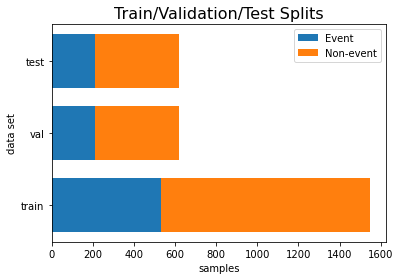

In [29]:
test_y = val_y
visualization.plot_split_counts(train_y, val_y, test_y)

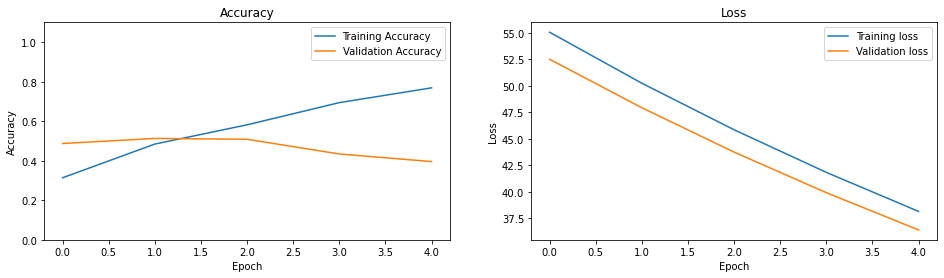

In [24]:
# plot learning curve
train_acc = history['acc']
val_acc = history['val_acc']
train_loss = history['loss']
val_loss = history['val_loss']
fig, (ax1,ax2) = plt.subplots(1,2, figsize=plt.figaspect(0.25))
ax1.plot(train_acc, label='Training Accuracy')
ax1.plot(val_acc, label='Validation Accuracy')
ax1.set_title('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0,1.1)
ax1.legend()

ax2.plot(train_loss, label='Training loss')
ax2.plot(val_loss, label='Validation loss')
ax2.set_title('Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

In [29]:
# plot learning curve
visualization.plot_learning_curve(history)

AttributeError: 'dict' object has no attribute 'history'

14/14 [==============================] - 0s 16ms/step
Recall: 0.97
Precision: 0.19
F1-score: 0.31
Accuracy: 0.27
Brier score:0.27115027576478046


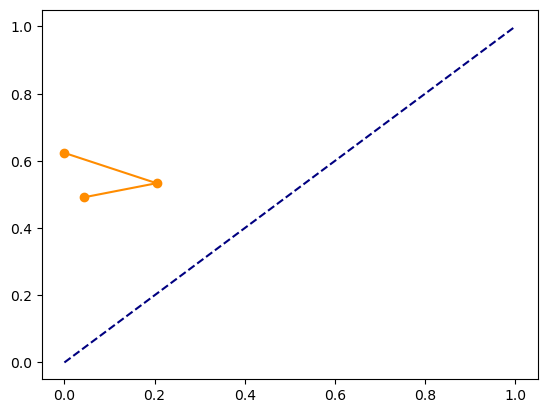

In [36]:
# evaluation
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve
test_predict = model.predict(test_X)
y_pred = np.argmax(model.predict(test_X),axis=1)
print('Recall: '+str(round(recall_score(test_y[:,1],y_pred),2)))
print('Precision: '+str(round(precision_score(test_y[:,1],y_pred),2)))
print('F1-score: '+str(round(f1_score(test_y[:,1],y_pred),2)))
print('Accuracy: '+str(round(accuracy_score(test_y[:,1],y_pred),2)))
print('Brier score:' +str(brier_score_loss(test_y[0:-20,1], test_predict[0:-20,1])))

calib_y, calib_x = calibration_curve(test_y[:,1],test_predict[:,1],n_bins=10)
visualization.plot_calibration_curve(calib_x, calib_y)

14/14 [==============================] - 0s 17ms/step
0.6384180790960453
(424,) (94,) (94,) (94,)


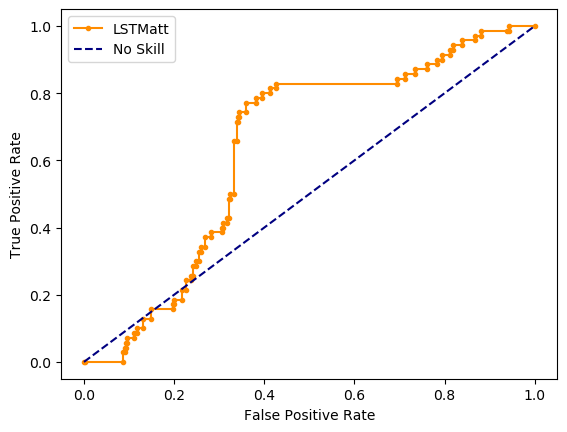

14/14 [==============================] - 0s 19ms/step
(424,) (406,) (406,)
f1=0.304 auc=0.204


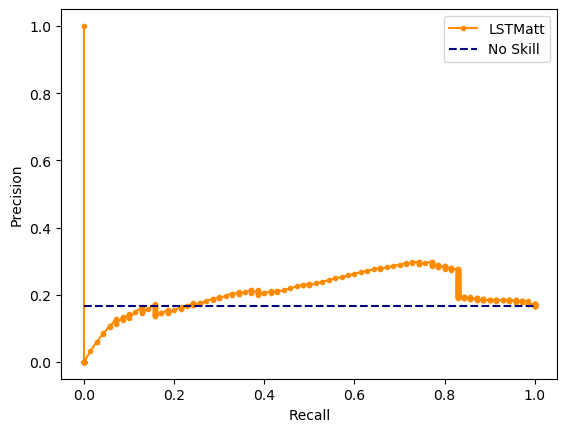

In [37]:
visualization.plot_roc_auc(model, test_X, test_y)

In [ ]:
# get weightings of each time step and each sample
intermediate_layer_model2 = Model(inputs=model.input,
                                 outputs=model.layers[3].output)

intermediate_layer_model1 = Model(inputs=model.input,
                                 outputs=model.layers[2].output)

intermediate_layer_model3 = Model(inputs=model.input,
                                 outputs=model.layers[4].output)

intermediate_output2, alfa_output = intermediate_layer_model2.predict(test_X, verbose=0)
intermediate_output1 = intermediate_layer_model1.predict(test_X, verbose=0)
intermediate_output3 = intermediate_layer_model3.predict(test_X, verbose=0)

weights = intermediate_output2 / intermediate_output1
print(np.shape(weights))

In [ ]:
# plot the weights
val_weights = np.ndarray((len(test_X),ntimestep))+np.nan
for ii in range(len(test_X)):
    for j in range(ntimestep):
        val_weights[ii,j] = weights[ii][j][0]
print(np.shape(val_weights))

fig, axs = plt.subplots(1, figsize=plt.figaspect(0.15))
for ii in range(len(test_X)):
    plt.plot(val_weights[ii,:])

fig, axs = plt.subplots(1, figsize=plt.figaspect(0.15))
plt.plot(np.nanmean(val_weights,axis=0),'k')

In [ ]:
# SST predictor
from eofs.xarray import Eof
file = xr.open_mfdataset(root_data+f'/era5_sst_1959-2021_1_12_daily_2.0deg.nc',
                          combine='by_coords',parallel=True)
#sst_dim = file.sel(longitude=slice(50,180),latitude=slice(40,-20))
sst_dim = file.sel(latitude=slice(40,-20))
lon = sst_dim.coords['longitude'].values
lat = sst_dim.coords['latitude'].values
nlon = len(lon)
nlat = len(lat)

sst_series = sst_dim.sel(time=sst_dim.time.dt.year.isin([np.arange(SYY,EYY+1)])).rolling(time=7, center=False).mean(skipna=True)
print(sst_series)

sst_anom_series = sst_series.groupby("time.dayofyear") - sst_series.groupby("time.dayofyear").mean("time",skipna=True)

# EOF focus on July to Sep
sst_anom_sel = sst_anom_series.sel(time=sst_anom_series.time.dt.month.isin([7,8,9,10,11]))['sst']
# first, make a grid out of the longitude and latitude vectors so they have the same dimensions 
lon2d,lat2d = np.meshgrid(lon,lat)
wgts = np.cos(lat2d/180*np.pi)**0.5
print(wgts.shape)
solver = Eof(sst_anom_sel,weights=wgts)

# EOFs are multiplied by the square-root of their eigenvalues (then the EOF patterns will carry the units)
nmode = 4
EOF = solver.eofs(neofs=nmode,eofscaling=2) # get the first four eofs
print(np.shape(EOF))
eigenv = solver.eigenvalues(neigs=nmode)
print(eigenv)
VarEx = solver.varianceFraction(neigs=nmode)*100
print(sum(VarEx))
PC = solver.pcs(npcs=nmode,pcscaling=1)
print(np.shape(PC))

mode = np.arange(nmode)
sst_anom_dim = sst_anom_series.sel(time=sst_anom_series.time.dt.month.isin([7,8,9,10,11]))
time_dim = sst_anom_dim.coords['time']
print(sst_anom_dim.coords['time'])
pc_xr = xr.DataArray(PC, coords={'time': time_dim, 'mode': mode}, dims=["time","mode"])
